In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from mcmc_optimization import optimize_via_mcmc
from models import TwoLayerNN
from data_samplers import BatchSampler
from proposal_generators import TwoLayerNNGaussianProposalGenerator, TwoLayerNNGibbsProposalGenerator
from functions import cross_entropy_loss, softmax
from time import time

In [2]:
digits_X, digits_y = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(digits_X, digits_y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

In [3]:
# Initial Parameters

intermediate_size1 = 30
final_size = 10

w1 = np.random.normal(loc=0,scale=1.0,size=(intermediate_size1,64))
b1 = np.random.normal(loc=0,scale=1.0,size=intermediate_size1)
w2 = np.random.normal(loc=0,scale=1.0,size=(final_size,intermediate_size1))
b2 = np.random.normal(loc=0,scale=1.0,size=final_size)

initial_params = {'w1':w1,'b1':b1,'w2':w2,'b2':b2}

In [14]:
data_sampler = BatchSampler(X=X_train, y=y_train)
#proposal_generator = TwoLayerNNGaussianProposalGenerator(scale=6,decay=1-1e-7)
proposal_generator = TwoLayerNNGibbsProposalGenerator(pct_entries_to_change=0.2, scale=5, decay=1-1e-7)
start = time()
best_params, history = optimize_via_mcmc(TwoLayerNN, initial_params, data_sampler,
                                         proposal_generator, cross_entropy_loss,
                                         beta=100, num_iterations=20000, batch_size=50)
time_elapsed = time() - start

print(time_elapsed, 'sec')

32.97991585731506 sec


In [15]:
print(f"Proportion of proposals accepted: {history['acceptance_ratio']:.4f}")
print(f"Best achieved loss: {min(history['loss_values']):.4f}")

Proportion of proposals accepted: 0.8185
Best achieved loss: 1.1543


In [16]:
best_model = TwoLayerNN(best_params['w1'],best_params['b1'],best_params['w2'],best_params['b2'])

In [18]:
#Check the test set
num_acc = 0
for i,item in enumerate(X_test):
    arg = np.argmax(best_model.forward(item))
    if arg == y_test[i]:
        num_acc += 1
accuracy = num_acc/len(y_test)
print(accuracy)

0.19444444444444445


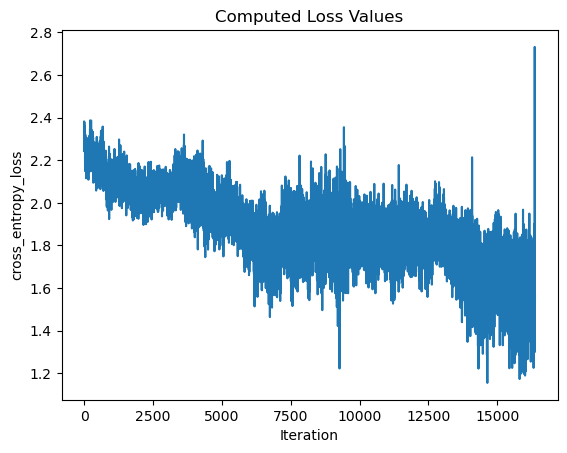

In [19]:
plt.title("Computed Loss Values")
plt.plot(history['loss_values'])
plt.ylabel("cross_entropy_loss")
plt.xlabel("Iteration")
plt.show()